In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy.ndimage import convolve
from scipy import ndimage
%matplotlib inline
import time
import copy
from numpy.lib.stride_tricks import as_strided

In [2]:
%load_ext autoreload
%autoreload 1
%aimport getBayer

In [3]:
Im = getBayer.getBayer('pic2.jpeg')
bayer = getBayer.bayerGrid 
rawIm = copy.deepcopy(Im)
R = rawIm[:,:,0].copy()
G = rawIm[:,:,1].copy()
B = rawIm[:,:,2].copy()

rgbSum = R+G+B
rgbSum[0:5,0:5]

array([[14,  7, 15,  9, 15],
       [16, 15, 12, 13, 13],
       [13,  8, 15,  7, 13],
       [12, 14, 11, 13, 14],
       [15,  8, 14,  6, 13]], dtype=uint8)

In [4]:
# kernels for processing
GatR = np.array([[0,0,-1,0,0],
                 [0,0,2,0,0],
                 [-1,2,4,2,-1],
                 [0,0,2,0,0],
                 [0,0,-1,0,0]])  # Green at red pixels
GatB = GatR
RatGRB = np.array([[0,0,.5,0,0],
                   [0,-1,0,-1,0],
                   [-1,4,5,4,-1],
                   [0,-1,0,-1,0],
                   [0,0,.5,0,0]])  # Red at Green, in Red row, Blue column
RatGBR = RatGRB.T
BatGBR = RatGRB
BatGRB = RatGBR
RatB = np.array([[0,0,-1.5,0,0],
                 [0,2,0,2,0],
                 [-1.5,0,6,0,-1.5],
                 [0,2,0,2,0],
                 [0,0,-1.5,0,0]])
BatR = RatB

Grows1 = slice(None,None,2)
Gcols1 = Grows1
Grows2 = slice(1,None,2)
Gcols2 = Grows2

Rrows = slice(1,None,2)
Rcols = slice(None,None,2)

Brows = slice(None,None,2)
Bcols = slice(1,None,2)

iGatR = (Rcols,Rrows)
iGatB = (Bcols,Brows)
iRatGRB = (Gcols1,Grows1)
iBatGRB = iRatGRB
iRatGBR = (Gcols2,Grows2)
iBatGBR = iRatGBR
iRatB = (Bcols,Brows)
iBatR = (Rcols,Rrows)

def debayer_malvar(img):
    def norm(k):
        return k / np.sum(k)
#         return k
    
    b = img.copy().sum(axis=2)  # flatten bayer data
    debayered = img.copy()
    
    dGatR = convolve(b, norm(GatR))
    debayered[Rrows,Rcols,1] = dGatR[Rrows,Rcols]
    debayered[Brows,Bcols,1] = dGatR[Brows,Bcols]
    
    dRatB = convolve(b, norm(RatB))
    debayered[Brows,Bcols,0] = dRatB[Brows,Bcols]
    debayered[Rrows,Rcols,2] = dRatB[Rrows,Rcols]
    
    dRatGRB = convolve(b, norm(RatGRB))
    debayered[Grows1,Gcols1,0] = dRatGRB[Grows1,Gcols1]
    debayered[Grows2,Gcols2,2] = dRatGRB[Grows2,Gcols2]
    
    dRatGBR = convolve(b, norm(RatGBR))
    debayered[Grows2,Gcols2,0] = dRatGBR[Grows2,Gcols2]
    debayered[Grows1,Gcols1,2] = dRatGBR[Grows1,Gcols1]
    return debayered

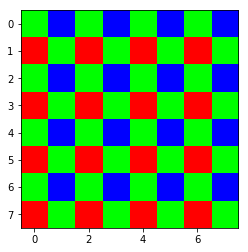

In [5]:
small_bayer = getBayer.get_bayer_grid(8,8)
plt.imshow(small_bayer.astype(np.float))

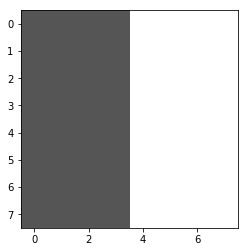

In [6]:
edge_example = np.ones((8,8,3), dtype=np.float)
edge_example[:,:4] = 1/3
plt.imshow(edge_example)

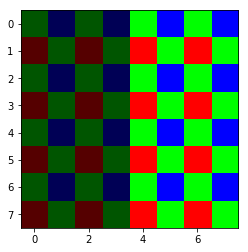

In [7]:
edge_bayerized = edge_example * small_bayer
plt.imshow(edge_bayerized)

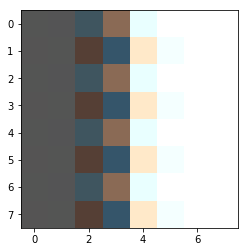

In [8]:
edge_debayerized = debayer_malvar(edge_bayerized)
plt.imshow(np.clip(edge_debayerized,0,1))

In [9]:
edge_debayerized

array([[[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333],
        [0.25      , 0.33333333, 0.375     ],
        [0.54166667, 0.41666667, 0.33333333],
        [0.91666667, 1.        , 1.125     ],
        [1.125     , 1.08333333, 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.25      , 0.20833333],
        [0.20833333, 0.33333333, 0.41666667],
        [1.        , 0.91666667, 0.79166667],
        [0.95833333, 1.        , 1.08333333],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333],
        [0.25      , 0.33333333, 0.375     ],
        [0.54166667, 0.41666667, 0.33333333],
        [0.91666667, 1.        , 1.125     ],
        [1.125     , 1.0833333

In [10]:
edge_debayerized[1,0,2]

0.33333333333333326

In [11]:
small_bayer[0,1,2]

True

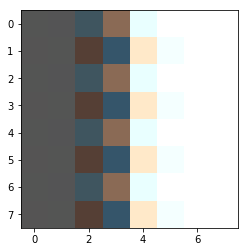

In [12]:
plt.imshow(np.clip(getBayer.debayer_malvar(edge_bayerized),0,1))